## 1. Import Libraries

In [52]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [53]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2.Display Settings

In [54]:
pd.set_option("display.max_column",None) #Display all the columns

In [55]:
sklearn.set_config(transform_output="pandas") # sklearn output pandas setting

In [56]:
warnings.filterwarnings("ignore")

## 3.Read the Data

In [57]:
path=r"C:\Users\Debasish Das\Desktop\Flight_Price_Prediction\Dataset\train.csv"
train=pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Multiple Carriers,2019-06-03,Delhi,Cochin,08:30:00,19:00:00,630,1.0,No Info,11200
1,Spicejet,2019-05-24,Kolkata,Banglore,11:35:00,18:50:00,435,1.0,No Info,8479
2,Jet Airways,2019-06-27,Delhi,Cochin,13:25:00,19:00:00,1775,2.0,In-flight meal not included,11150
3,Air India,2019-06-12,Kolkata,Banglore,10:00:00,13:45:00,1665,2.0,No Info,12224
4,Indigo,2019-06-24,Delhi,Cochin,16:10:00,22:30:00,380,1.0,No Info,6412
...,...,...,...,...,...,...,...,...,...,...
6395,Vistara,2019-05-15,Kolkata,Banglore,17:00:00,23:25:00,385,1.0,No Info,9345
6396,Air India,2019-06-15,Chennai,Kolkata,11:40:00,13:55:00,135,0.0,No Info,4667
6397,Multiple Carriers,2019-06-27,Delhi,Cochin,14:00:00,21:00:00,420,1.0,No Info,13587
6398,Indigo,2019-06-21,Banglore,Delhi,13:00:00,15:50:00,170,0.0,No Info,3943


In [58]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6400 entries, 0 to 6399
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6400 non-null   object 
 1   date_of_journey  6400 non-null   object 
 2   source           6400 non-null   object 
 3   destination      6400 non-null   object 
 4   dep_time         6400 non-null   object 
 5   arrival_time     6400 non-null   object 
 6   duration         6400 non-null   int64  
 7   total_stops      6399 non-null   float64
 8   additional_info  6400 non-null   object 
 9   price            6400 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 500.1+ KB


In [59]:
x_train=train.drop(columns="price")
y_train=train.price.copy()

## 4. Tranformation Opration

### 4.1. Airline

In [60]:
x_train.airline

0       Multiple Carriers
1                Spicejet
2             Jet Airways
3               Air India
4                  Indigo
              ...        
6395              Vistara
6396            Air India
6397    Multiple Carriers
6398               Indigo
6399            Air India
Name: airline, Length: 6400, dtype: object

In [61]:
air_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("grouper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
air_transformer.fit_transform(x_train.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...
6395,0.0,0.0,0.0,0.0,1.0
6396,1.0,0.0,0.0,0.0,0.0
6397,0.0,0.0,0.0,1.0,0.0
6398,0.0,1.0,0.0,0.0,0.0


### 4.2. Date of Journey

In [62]:
train.date_of_journey

0       2019-06-03
1       2019-05-24
2       2019-06-27
3       2019-06-12
4       2019-06-24
           ...    
6395    2019-05-15
6396    2019-06-15
6397    2019-06-27
6398    2019-06-21
6399    2019-05-06
Name: date_of_journey, Length: 6400, dtype: object

In [63]:
feature_extract=["month", "week", "day_of_week", 'day_of_month', "day_of_year", "weekend"]
doj_transfrom= Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=feature_extract,yearfirst=True,format="mixed")),
    ("sclar",MinMaxScaler())
])
doj_transfrom.fit_transform(x_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_month,date_of_journey_day_of_year,date_of_journey_weekend
0,1.000000,0.823529,0.000000,0.076923,0.796610,0.0
1,0.666667,0.705882,0.666667,0.884615,0.711864,0.0
2,1.000000,1.000000,0.500000,1.000000,1.000000,0.0
3,1.000000,0.882353,0.333333,0.423077,0.872881,0.0
4,1.000000,1.000000,0.000000,0.884615,0.974576,0.0
...,...,...,...,...,...,...
6395,0.666667,0.647059,0.333333,0.538462,0.635593,0.0
6396,1.000000,0.882353,0.833333,0.538462,0.898305,1.0
6397,1.000000,1.000000,0.500000,1.000000,1.000000,0.0
6398,1.000000,0.941176,0.666667,0.769231,0.949153,0.0


### 4.3. Source & destination

In [64]:
train.source

0          Delhi
1        Kolkata
2          Delhi
3        Kolkata
4          Delhi
          ...   
6395     Kolkata
6396     Chennai
6397       Delhi
6398    Banglore
6399     Kolkata
Name: source, Length: 6400, dtype: object

In [65]:
train.destination

0         Cochin
1       Banglore
2         Cochin
3       Banglore
4         Cochin
          ...   
6395    Banglore
6396     Kolkata
6397      Cochin
6398       Delhi
6399    Banglore
Name: destination, Length: 6400, dtype: object

In [66]:
location_subset=x_train.loc[:,["source","destination"]]
location_pipe=Pipeline(steps=[
    ("groper",RareLabelEncoder(tol=0.1,replace_with="other",n_categories=2)),
    ("encoder",MeanEncoder()),
    ("sclar",PowerTransformer())
])
location_pipe.fit_transform(location_subset,y_train )

,source,destination
0,1.054282,1.053119
1,-0.255110,-0.256634
2,1.054282,1.053119
3,-0.255110,-0.256634
4,1.054282,1.053119
...,...,...
6395,-0.255110,-0.256634
6396,-1.933380,-0.779365
6397,1.054282,1.053119
6398,-0.820210,-1.886866


In [67]:
np.union1d(
    x_train.source.unique(),
     x_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [68]:
def is_north(X):
    column=X.columns.to_list()
    north=["Delhi","kolkata","New Delhi","Mumbai"]
    return (
        X.assign(
            **{
                f"{col}_is_north": X.loc[:,col].isin(north).astype(int)
                for col in column
            }
        )
        .drop(columns=location_subset)
    )
FunctionTransformer(func=is_north).fit_transform(location_subset)
    

,source_is_north,destination_is_north
0,1,0
1,0,0
2,1,0
3,0,0
4,1,0
...,...,...
6395,0,0
6396,0,0
6397,1,0
6398,0,1


### 4.4 dep_time & arrival_time

In [69]:
train.dep_time

0       08:30:00
1       11:35:00
2       13:25:00
3       10:00:00
4       16:10:00
          ...   
6395    17:00:00
6396    11:40:00
6397    14:00:00
6398    13:00:00
6399    12:00:00
Name: dep_time, Length: 6400, dtype: object

In [70]:
train.arrival_time

0       19:00:00
1       18:50:00
2       19:00:00
3       13:45:00
4       22:30:00
          ...   
6395    23:25:00
6396    13:55:00
6397    21:00:00
6398    15:50:00
6399    21:50:00
Name: arrival_time, Length: 6400, dtype: object

In [71]:
time_subset=x_train.loc[:,["dep_time","arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:30:00,19:00:00
1,11:35:00,18:50:00
2,13:25:00,19:00:00
3,10:00:00,13:45:00
4,16:10:00,22:30:00
...,...,...
6395,17:00:00,23:25:00
6396,11:40:00,13:55:00
6397,14:00:00,21:00:00
6398,13:00:00,15:50:00


In [72]:
time_pipe1=Pipeline(steps=[
    ("dt",DatetimeFeatures(features_to_extract=["hour","minute"])),
    ("sclar",MinMaxScaler())
])
time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,0.545455,0.826087,0.000000
1,0.478261,0.636364,0.782609,0.909091
2,0.565217,0.454545,0.826087,0.000000
3,0.434783,0.000000,0.565217,0.818182
4,0.695652,0.181818,0.956522,0.545455
...,...,...,...,...
6395,0.739130,0.000000,1.000000,0.454545
6396,0.478261,0.727273,0.565217,1.000000
6397,0.608696,0.000000,0.913043,0.000000
6398,0.565217,0.000000,0.652174,0.909091


In [73]:
def part_of_day(x,morning=4,noon=12,evening=16,night=20):
   columns=x.columns.to_list()
   X_temp=x.assign(**{
       col:pd.to_datetime(x.loc[:,col]).dt.hour
       for col in columns
   })
   return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, evening, inclusive="left"),
				 X_temp.loc[:, col].between(evening, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,morning,evening
2,afternoon,evening
3,morning,afternoon
4,evening,night
...,...,...
6395,evening,night
6396,morning,afternoon
6397,afternoon,night
6398,afternoon,afternoon


In [74]:
time_pipe2=Pipeline(steps=[
    ("part",FunctionTransformer(func=part_of_day)),
    ("encoder",CountFrequencyEncoder()),
    ("sclar",MinMaxScaler())
])
time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.662231
1,1.000000,0.662231
2,0.000000,0.662231
3,1.000000,0.000000
4,0.223807,1.000000
...,...,...
6395,0.223807,1.000000
6396,1.000000,0.000000
6397,0.000000,1.000000
6398,0.000000,0.000000


In [75]:
time_transfrom=FeatureUnion(transformer_list=[
    ("part1",time_pipe1),
    ("part2",time_pipe2)
])
time_transfrom.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,0.545455,0.826087,0.000000,1.000000,0.662231
1,0.478261,0.636364,0.782609,0.909091,1.000000,0.662231
2,0.565217,0.454545,0.826087,0.000000,0.000000,0.662231
3,0.434783,0.000000,0.565217,0.818182,1.000000,0.000000
4,0.695652,0.181818,0.956522,0.545455,0.223807,1.000000
...,...,...,...,...,...,...
6395,0.739130,0.000000,1.000000,0.454545,0.223807,1.000000
6396,0.478261,0.727273,0.565217,1.000000,1.000000,0.000000
6397,0.608696,0.000000,0.913043,0.000000,0.000000,1.000000
6398,0.565217,0.000000,0.652174,0.909091,0.000000,0.000000


### 4.5 Duration

In [76]:
x_train.duration

0        630
1        435
2       1775
3       1665
4        380
        ... 
6395     385
6396     135
6397     420
6398     170
6399     590
Name: duration, Length: 6400, dtype: int64

In [77]:
x_train.total_stops=x_train.total_stops.fillna(0)

In [78]:
(
    x_train.duration
    .quantile([0.25,0.50,0.75])
    .values
    .reshape(-1,1)
)

array([[170.],
       [515.],
       [910.]])

In [79]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variable=None, percentiles=[0.25, 0.50, 0.75], gamma=0.5):
        self.variable = variable
        self.percentiles = percentiles
        self.gamma = gamma
        self.reference = None
        
    def fit(self, X, y=None):
        if self.variable is None:
            self.variable = X.select_dtypes(include="number").columns.tolist()
        
        self.reference = {
            col: X.loc[:, col].quantile(self.percentiles).values.reshape(-1, 1)
            for col in self.variable
        }
        return self
    
    def transform(self, X):
        objects = []
        for col in self.variable:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

In [80]:
RBFPercentileSimilarity().fit_transform(x_train)

,duration_rbf_25,duration_rbf_50,duration_rbf_75,total_stops_rbf_25,total_stops_rbf_50,total_stops_rbf_75
0,0.000000e+00,0.0,0.0,0.606531,1.000000,1.000000
1,0.000000e+00,0.0,0.0,0.606531,1.000000,1.000000
2,0.000000e+00,0.0,0.0,0.135335,0.606531,0.606531
3,0.000000e+00,0.0,0.0,0.135335,0.606531,0.606531
4,0.000000e+00,0.0,0.0,0.606531,1.000000,1.000000
...,...,...,...,...,...,...
6395,0.000000e+00,0.0,0.0,0.606531,1.000000,1.000000
6396,9.877109e-267,0.0,0.0,1.000000,0.606531,0.606531
6397,0.000000e+00,0.0,0.0,0.606531,1.000000,1.000000
6398,1.000000e+00,0.0,0.0,1.000000,0.606531,0.606531


In [93]:
def duration_catagory(x,short=180,med=400):
    return(
        x
		.assign(duration_cat=np.select([x.duration.lt(short),
									    x.duration.between(short, med, inclusive="left")],
									   ["short", "med"],
									   default="long"))
		.drop(columns="duration")
	)
    

In [96]:
def is_over(x,value=1000):
    return(
        x.assign(
            **{
                f"duration_over_{value}": x.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
    )

In [97]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2=Pipeline(steps=[
    ("cat",FunctionTransformer(func=duration_catagory)),
    ("encoder",OrdinalEncoder(categories=[["short","med","long"]]))
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3",FunctionTransformer(func=is_over)),
    ("part4",StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outlierd", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(x_train[["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.225651,-0.047389,-0.068658,2.0,0,-0.005314
1,-0.225651,-0.047389,-0.068658,2.0,0,-0.398762
2,-0.225651,-0.047389,-0.068658,2.0,1,2.304935
3,-0.225651,-0.047389,-0.068658,2.0,1,2.082990
4,-0.225651,-0.047389,-0.068658,1.0,0,-0.509735
...,...,...,...,...,...,...
6395,-0.225651,-0.047389,-0.068658,1.0,0,-0.499647
6396,-0.225651,-0.047389,-0.068658,0.0,0,-1.004068
6397,-0.225651,-0.047389,-0.068658,2.0,0,-0.429028
6398,4.432286,-0.047389,-0.068658,0.0,0,-0.933449


### 4.6. Total stops

In [98]:

x_train.total_stops

0       1.0
1       1.0
2       2.0
3       2.0
4       1.0
       ... 
6395    1.0
6396    0.0
6397    1.0
6398    0.0
6399    2.0
Name: total_stops, Length: 6400, dtype: float64

In [99]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])


In [100]:
total_stops_transformer.fit_transform(x_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,1.0,0
2,2.0,0
3,2.0,0
4,1.0,0
...,...,...
6395,1.0,0
6396,0.0,1
6397,1.0,0
6398,0.0,1


### 4.7. additional Info

In [101]:

x_train.additional_info

0                           No Info
1                           No Info
2       In-flight meal not included
3                           No Info
4                           No Info
                   ...             
6395                        No Info
6396                        No Info
6397                        No Info
6398                        No Info
6399                        No Info
Name: additional_info, Length: 6400, dtype: object

In [102]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
info_pipe1.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6395,0.0,1.0,0.0
6396,0.0,1.0,0.0
6397,0.0,1.0,0.0
6398,0.0,1.0,0.0


In [103]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [104]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [105]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6395,0.0,1.0,0.0,0
6396,0.0,1.0,0.0,0
6397,0.0,1.0,0.0,0
6398,0.0,1.0,0.0,0


## 5. Column Transformer

In [109]:
Column_Transformer=ColumnTransformer(transformers=[
    ("air",air_transformer,["airline"]),
    ("doj",doj_transfrom,["date_of_journey"]),
    ("time",time_transfrom,["arrival_time","dep_time"]),
    ("dur",duration_transformer,["duration"]),
     ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
],remainder="passthrough")
Column_Transformer.fit_transform(x_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_month,doj__date_of_journey_day_of_year,doj__date_of_journey_weekend,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_hour,time__dep_time_minute,time__arrival_time_part_of_day,time__dep_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info,remainder__source,remainder__destination
0,0.0,0.0,0.0,1.0,0.0,1.000000,0.823529,0.000000,0.076923,0.796610,0.0,0.826087,0.000000,0.347826,0.545455,0.662231,1.000000,-0.225651,-0.047389,-0.068658,2.0,0,-0.005314,1.0,0,0.0,1.0,0.0,0,Delhi,Cochin
1,0.0,0.0,0.0,0.0,1.0,0.666667,0.705882,0.666667,0.884615,0.711864,0.0,0.782609,0.909091,0.478261,0.636364,0.662231,1.000000,-0.225651,-0.047389,-0.068658,2.0,0,-0.398762,1.0,0,0.0,1.0,0.0,0,Kolkata,Banglore
2,0.0,0.0,1.0,0.0,0.0,1.000000,1.000000,0.500000,1.000000,1.000000,0.0,0.826087,0.000000,0.565217,0.454545,0.662231,0.000000,-0.225651,-0.047389,-0.068658,2.0,1,2.304935,2.0,0,1.0,0.0,0.0,1,Delhi,Cochin
3,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.333333,0.423077,0.872881,0.0,0.565217,0.818182,0.434783,0.000000,0.000000,1.000000,-0.225651,-0.047389,-0.068658,2.0,1,2.082990,2.0,0,0.0,1.0,0.0,0,Kolkata,Banglore
4,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.884615,0.974576,0.0,0.956522,0.545455,0.695652,0.181818,1.000000,0.223807,-0.225651,-0.047389,-0.068658,1.0,0,-0.509735,1.0,0,0.0,1.0,0.0,0,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.333333,0.538462,0.635593,0.0,1.000000,0.454545,0.739130,0.000000,1.000000,0.223807,-0.225651,-0.047389,-0.068658,1.0,0,-0.499647,1.0,0,0.0,1.0,0.0,0,Kolkata,Banglore
6396,1.0,0.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.538462,0.898305,1.0,0.565217,1.000000,0.478261,0.727273,0.000000,1.000000,-0.225651,-0.047389,-0.068658,0.0,0,-1.004068,0.0,1,0.0,1.0,0.0,0,Chennai,Kolkata
6397,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.500000,1.000000,1.000000,0.0,0.913043,0.000000,0.608696,0.000000,1.000000,0.000000,-0.225651,-0.047389,-0.068658,2.0,0,-0.429028,1.0,0,0.0,1.0,0.0,0,Delhi,Cochin
6398,0.0,1.0,0.0,0.0,0.0,1.000000,0.941176,0.666667,0.769231,0.949153,0.0,0.652174,0.909091,0.565217,0.000000,0.000000,0.000000,4.432286,-0.047389,-0.068658,0.0,0,-0.933449,0.0,1,0.0,1.0,0.0,0,Banglore,Delhi


## 6. Feature Selection

In [110]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. Putting all Together

In [111]:

preprocessor = Pipeline(steps=[
	("ct", Column_Transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,remainder__source,remainder__destination
0,0.0,0.0,0.0,0.823529,0.796610,2.0,0,-0.005314,1.0,0,Delhi,Cochin
1,0.0,0.0,1.0,0.705882,0.711864,2.0,0,-0.398762,1.0,0,Kolkata,Banglore
2,0.0,1.0,0.0,1.000000,1.000000,2.0,1,2.304935,2.0,0,Delhi,Cochin
3,0.0,0.0,0.0,0.882353,0.872881,2.0,1,2.082990,2.0,0,Kolkata,Banglore
4,1.0,0.0,0.0,1.000000,0.974576,1.0,0,-0.509735,1.0,0,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,1.0,0.647059,0.635593,1.0,0,-0.499647,1.0,0,Kolkata,Banglore
6396,0.0,0.0,0.0,0.882353,0.898305,0.0,0,-1.004068,0.0,1,Chennai,Kolkata
6397,0.0,0.0,0.0,1.000000,1.000000,2.0,0,-0.429028,1.0,0,Delhi,Cochin
6398,1.0,0.0,0.0,0.941176,0.949153,0.0,0,-0.933449,0.0,1,Banglore,Delhi


In [114]:

preprocessor = Pipeline(steps=[
	("ct", Column_Transformer),
	("selector", selector)
])

preprocessor.fit_transform(x_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,remainder__source,remainder__destination
0,0.0,0.0,0.0,0.823529,0.796610,2.0,0,-0.005314,1.0,0,Delhi,Cochin
1,0.0,0.0,1.0,0.705882,0.711864,2.0,0,-0.398762,1.0,0,Kolkata,Banglore
2,0.0,1.0,0.0,1.000000,1.000000,2.0,1,2.304935,2.0,0,Delhi,Cochin
3,0.0,0.0,0.0,0.882353,0.872881,2.0,1,2.082990,2.0,0,Kolkata,Banglore
4,1.0,0.0,0.0,1.000000,0.974576,1.0,0,-0.509735,1.0,0,Delhi,Cochin
...,...,...,...,...,...,...,...,...,...,...,...,...
6395,0.0,0.0,1.0,0.647059,0.635593,1.0,0,-0.499647,1.0,0,Kolkata,Banglore
6396,0.0,0.0,0.0,0.882353,0.898305,0.0,0,-1.004068,0.0,1,Chennai,Kolkata
6397,0.0,0.0,0.0,1.000000,1.000000,2.0,0,-0.429028,1.0,0,Delhi,Cochin
6398,1.0,0.0,0.0,0.941176,0.949153,0.0,0,-0.933449,0.0,1,Banglore,Delhi


## 8. Visualization

In [116]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(0.0017159984561240609),
 'air__airline_Indigo': np.float64(0.1182121716757502),
 'air__airline_Jet Airways': np.float64(0.17204926797464615),
 'air__airline_Multiple Carriers': np.float64(0.01773520081829949),
 'air__airline_other': np.float64(0.11073041924392424),
 'doj__date_of_journey_month': np.float64(0.08176325015554668),
 'doj__date_of_journey_week': np.float64(0.17811950382943323),
 'doj__date_of_journey_day_of_week': np.float64(0.005080526058509838),
 'doj__date_of_journey_day_of_month': np.float64(0.03451366299926458),
 'doj__date_of_journey_day_of_year': np.float64(0.215619128500247),
 'doj__date_of_journey_weekend': np.float64(-0.0005106924688997871),
 'time__arrival_time_hour': np.float64(0.05751813621451877),
 'time__arrival_time_minute': np.float64(0.030582208062969962),
 'time__dep_time_hour': np.float64(0.011022209815658823),
 'time__dep_time_minute': np.float64(0.03127806870231272),
 'time__arrival_time_part_of_day': np.float64(0.

In [117]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_50': np.float64(-0.0016898513842706537),
 'time__dep_time_part_of_day': np.float64(-0.0012205448239168692),
 'info__additional_info_No Info': np.float64(-0.0007260573555817699),
 'info__additional_info': np.float64(-0.0007260573555817699),
 'doj__date_of_journey_weekend': np.float64(-0.0005106924688997871),
 'dur__duration_rbf_75': np.float64(-0.00022941160600109534),
 'info__additional_info_In-flight meal not included': np.float64(9.654065538348504e-05),
 'air__airline_Air India': np.float64(0.0017159984561240609),
 'doj__date_of_journey_day_of_week': np.float64(0.005080526058509838),
 'time__dep_time_hour': np.float64(0.011022209815658823),
 'info__additional_info_Other': np.float64(0.013699834052202728),
 'air__airline_Multiple Carriers': np.float64(0.01773520081829949),
 'time__arrival_time_part_of_day': np.float64(0.023910131608856095),
 'time__arrival_time_minute': np.float64(0.030582208062969962),
 'time__dep_time_minute': np.float64(0.03127806870231272),
 'd

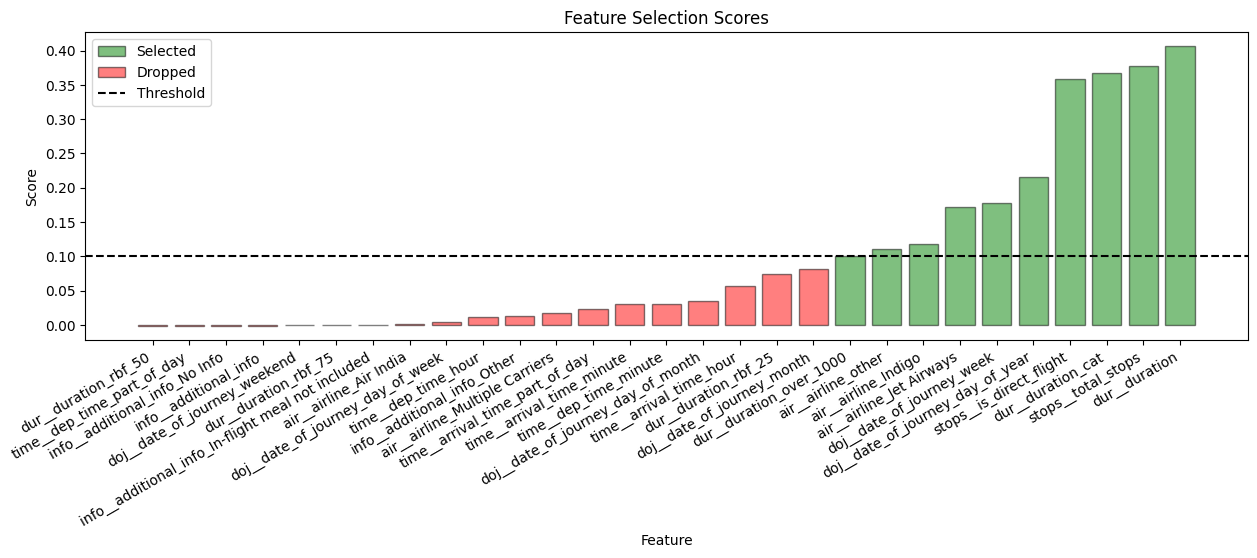

In [118]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()